# Assassin Classifier

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import *

## Extract CSV Files

In [ ]:
base_path = Path(".")
urls_dir = base_path/'assassins'

In [ ]:
! unzip -nq "assassins.zip" -d {str(base_path)}

## Get class names

In [57]:
classes = []
for csv_file in urls_dir.ls():
  if csv_file.suffix == ".csv":
    classes.append(csv_file.stem)

print(classes)

['bayek', 'ezio', 'edward', 'jacob', 'connor', 'shay', 'evie', 'kass', 'altair', 'arno', 'alexios']


## Download image files

In [ ]:
data_dir = base_path/'data'

In [ ]:
for class_name in classes:
  class_dir = data_dir/class_name
  class_dir.mkdir(parents=True, exist_ok=True)
  csv_file = urls_dir/f"{class_name}.csv"
  download_images(csv_file, dest=class_dir, max_pics=350)
  verify_images(class_dir, delete=True, max_size=500)

## Create Data bunch

In [ ]:
data_bunch = ImageDataBunch.from_folder(data_dir, valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=32).normalize(imagenet_stats)

In [8]:
data_bunch.classes

['alexios',
 'altair',
 'arno',
 'bayek',
 'connor',
 'edward',
 'evie',
 'ezio',
 'jacob',
 'kass',
 'shay']

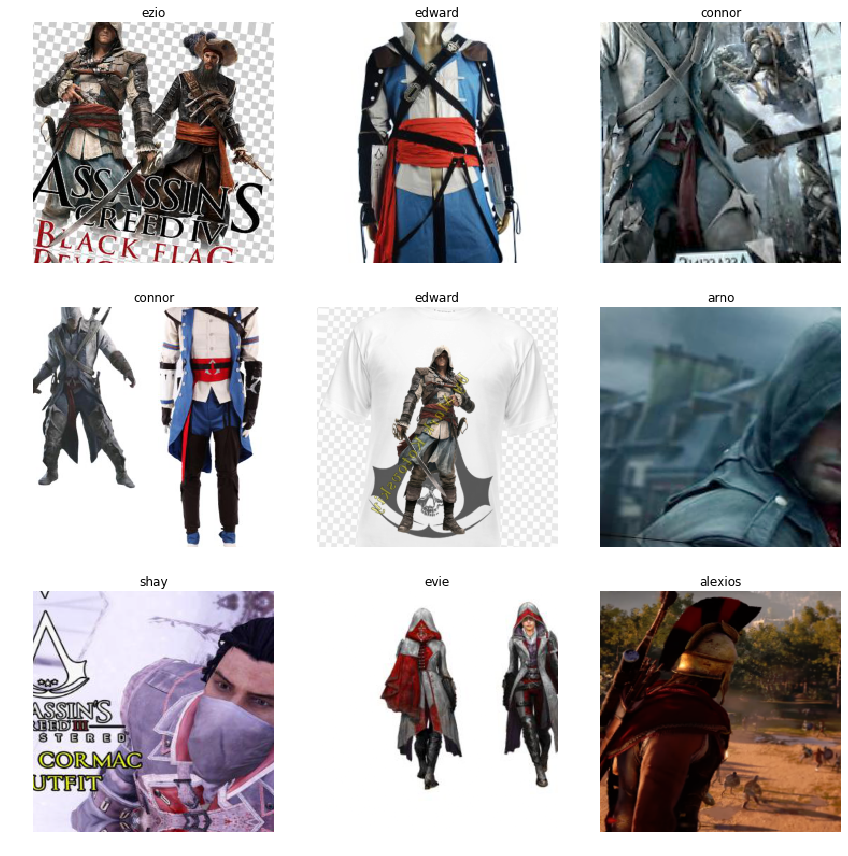

In [70]:
data_bunch.show_batch(rows=3)

## Train Model

In [ ]:
learn = cnn_learner(data_bunch, models.resnet34, metrics=accuracy)

In [73]:
learn.fit_one_cycle(4)

In [ ]:
learn.save("uncleaned-stage1")

## Fine Tuning

In [ ]:
learn.freeze()

In [78]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


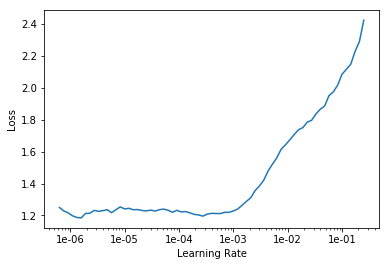

In [79]:
learn.recorder.plot()

In [80]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

In [ ]:
learn.unfreeze()

In [ ]:
learn.save("uncleaned-stage2")

## Training some more

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


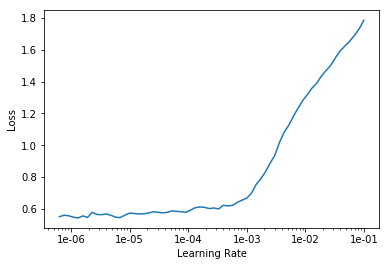

In [14]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(5, 1e-5)

In [ ]:
learn.save("uncleaned-stage3")

## Evaluation

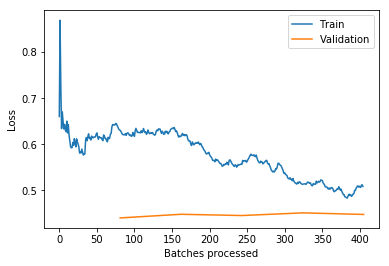

In [17]:
learn.recorder.plot_losses()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

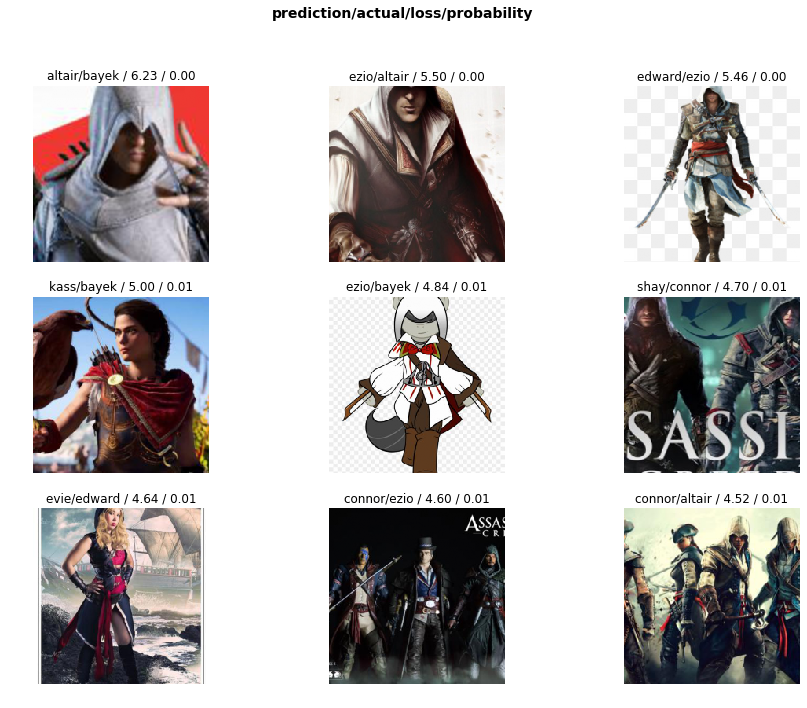

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

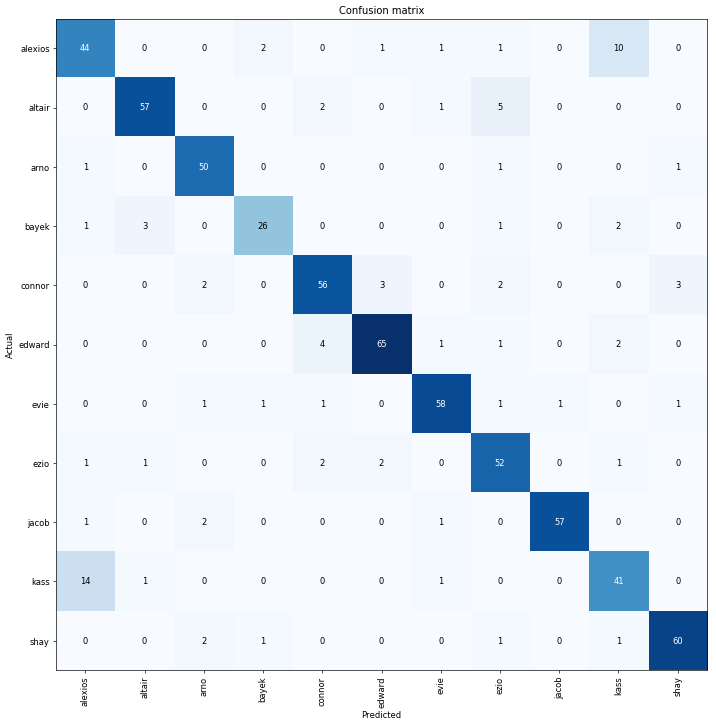

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
interp.most_confused(5)

[('kass', 'alexios', 14), ('alexios', 'kass', 10), ('altair', 'ezio', 5)]

In [ ]:
learn.export()

## Predicting

In [ ]:
predictor = load_learner(data_dir)

In [46]:
# ! wget "https://i.ytimg.com/vi/1qv7nS2IWxU/maxresdefault.jpg" 

--2019-09-03 12:34:15--  https://i.ytimg.com/vi/1qv7nS2IWxU/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 74.125.20.119, 74.125.142.119, 74.125.195.119, ...
Connecting to i.ytimg.com (i.ytimg.com)|74.125.20.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184299 (180K) [image/jpeg]
Saving to: ‘maxresdefault.jpg’

maxresdefault.jpg   100%[===================>] 179.98K  --.-KB/s    in 0.001s  

2019-09-03 12:34:15 (119 MB/s) - ‘maxresdefault.jpg’ saved [184299/184299]



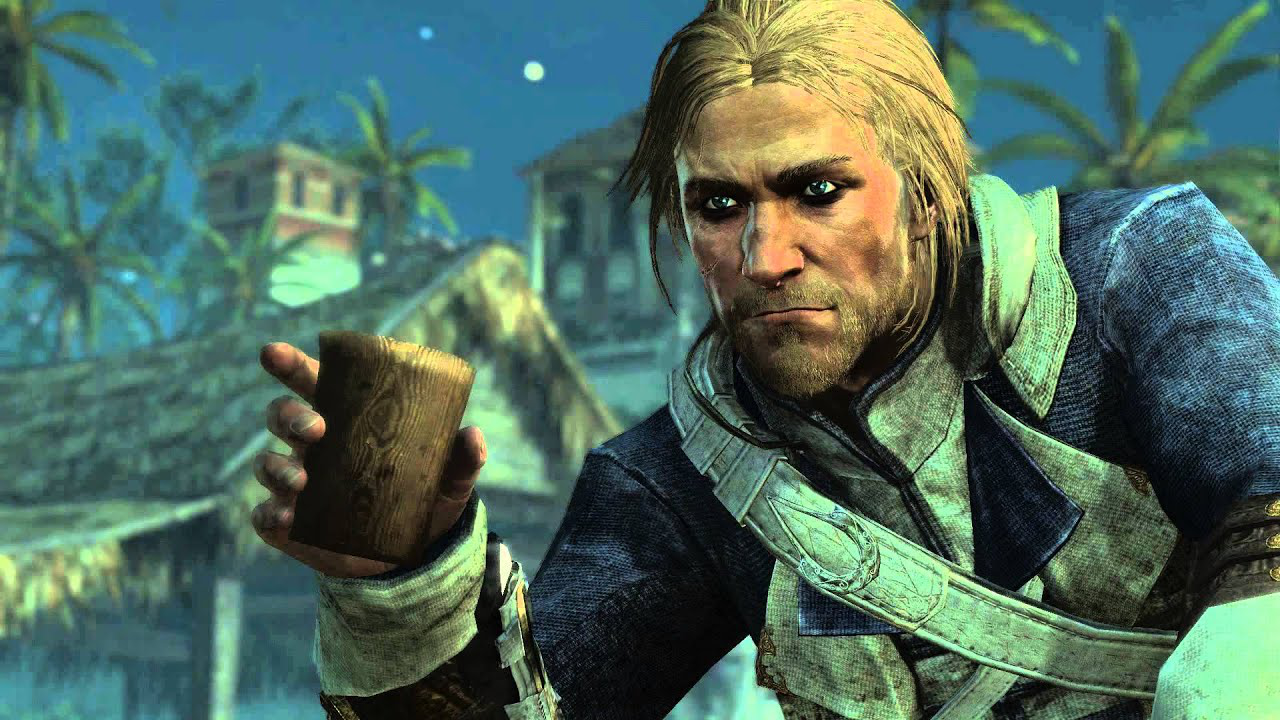

In [47]:
img = open_image("maxresdefault.jpg"); img

In [48]:
predictor.predict(img)

(Category edward,
 tensor(5),
 tensor([0.0791, 0.0524, 0.0186, 0.0175, 0.0057, 0.4151, 0.0042, 0.0022, 0.0236,
         0.0047, 0.3770]))

In [50]:
# ! wget "https://i.ytimg.com/vi/NQG2EKlF1mU/maxresdefault.jpg" 

--2019-09-03 12:39:42--  https://i.ytimg.com/vi/NQG2EKlF1mU/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 74.125.142.119, 74.125.195.119, 2607:f8b0:400e:c05::77
Connecting to i.ytimg.com (i.ytimg.com)|74.125.142.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48194 (47K) [image/jpeg]
Saving to: ‘maxresdefault.jpg.1’

maxresdefault.jpg.1 100%[===================>]  47.06K  --.-KB/s    in 0s      

2019-09-03 12:39:42 (98.4 MB/s) - ‘maxresdefault.jpg.1’ saved [48194/48194]



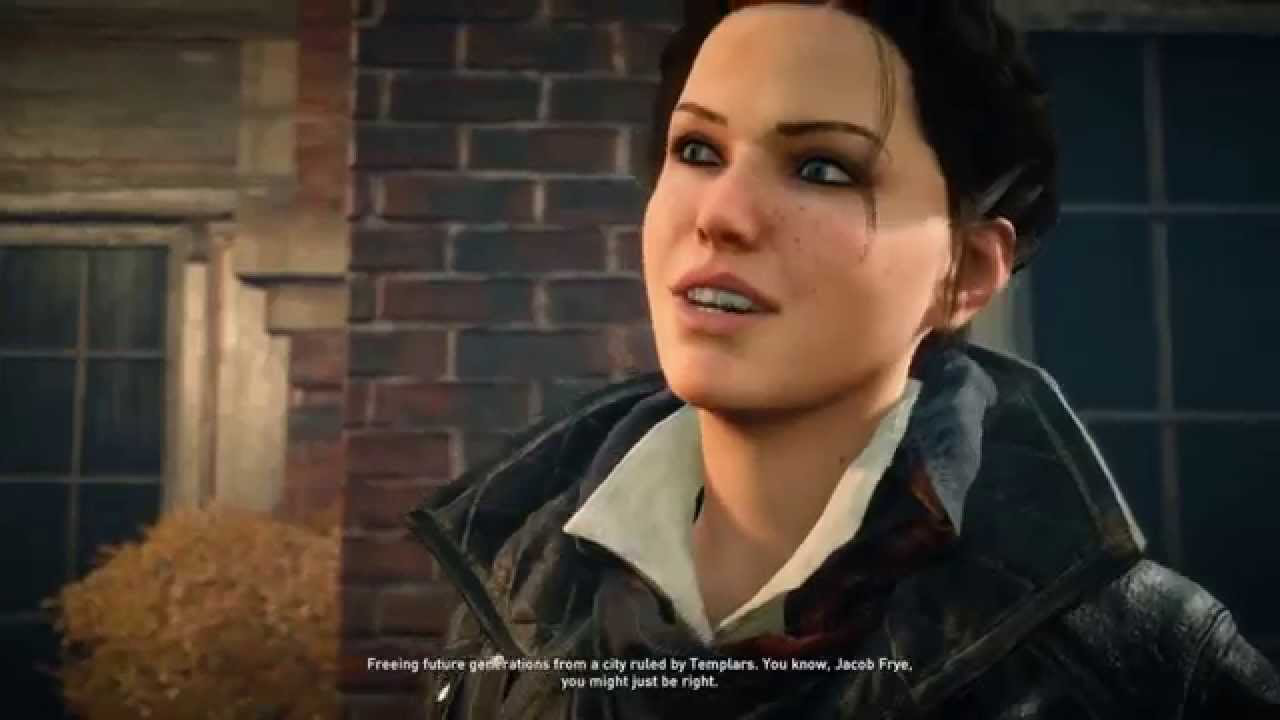

In [51]:
img = open_image("maxresdefault.jpg.1"); img

In [52]:
predictor.predict(img)

(Category evie,
 tensor(6),
 tensor([3.4677e-04, 7.0179e-04, 2.7585e-02, 5.7345e-04, 1.4476e-03, 3.0004e-03,
         9.1312e-01, 2.1573e-03, 4.7108e-02, 1.0535e-03, 2.9062e-03]))